In [674]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from utils import rmspe

In [675]:
import torch 
from torch import optim

In [676]:
from sklearn.model_selection import train_test_split

In [677]:
train_targets = pd.read_csv('train.csv')

In [678]:
import os
import re
stock_ids = sorted(
    [int(re.sub('stock_id=', '', x)) for x in os.listdir('book_train.parquet')])


In [679]:
stock_id = stock_ids[105]

In [680]:
book = pd.read_parquet('book_train.parquet/stock_id=' + str(stock_id))

In [681]:
book['wap'] = (book['bid_price1'] * book['ask_size1'] + book['ask_price1'] * book['bid_size1']) / (
    book['ask_size1'] + book['bid_size1'])
    
book['log_price'] = np.log(book['wap'])
book['log_return'] = book.groupby(['time_id'])['log_price'].diff()
book['square_return'] = book['log_return'] ** 2
book = book[~book['log_return'].isnull()]
book['stock_id'] = stock_id

In [682]:
book = pd.merge(book, train_targets, how='left', on=['time_id', 'stock_id'])

In [683]:
X = pd.pivot_table(book, 
                   values='square_return', 
                   columns=['seconds_in_bucket'], 
                   index='time_id', aggfunc='last')

X = X.fillna(0)
y = train_targets[train_targets.stock_id == stock_id].set_index('time_id')['target'].loc[X.index]
#X = X.values

In [684]:
#X = np.concatenate([X, X**2], axis=1)

In [685]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train = torch.tensor(X_train.values)
X_test = torch.tensor(X_test.values)

y_train = torch.tensor(y_train.values)
y_test = torch.tensor(y_test.values)

In [686]:
weights = torch.ones(X_train.shape[1], requires_grad=True)l
weights_poly = torch.tensor([ 1., 0.], requires_grad=True)

In [687]:
def my_loss(y_true, y_pred):
    return torch.sqrt(torch.mean(torch.square((y_true - y_pred) / y_true)))

In [648]:
opt = optim.Adam([weights, weights_poly], lr=0.1)
alpha = 1
beta = 1

In [649]:
train_loss_history = []
test_loss_history = []

In [650]:

for n in range(1000):
    y_pred_temp = torch.matmul(X_train, weights) ** 0.5
    y_pred_test_temp = torch.matmul(X_test, weights) ** 0.5
    
    y_pred = y_pred_temp * weights_poly[0] + y_pred_temp**2 * weights_poly[1]
    
        
    y_pred_test = y_pred_test_temp * weights_poly[0] + y_pred_test_temp**2 * weights_poly[1] 
    
    reg = weights[:-1] - weights[1: ]
    loss = my_loss(y_train, y_pred) + torch.sum(reg[reg > 0] ** 2) * alpha + torch.sum(weights[weights < 0] ** 2)
    
    loss_train = my_loss(y_train, y_pred)
    loss_test = my_loss(y_test, y_pred_test)
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    train_loss_history.append(float(loss_train.detach().numpy()))
    test_loss_history.append(float(loss_test.detach().numpy()))

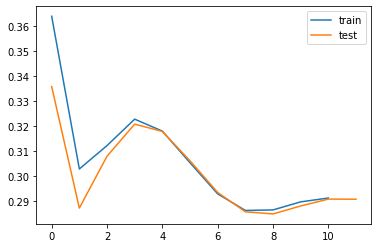

In [651]:
plt.plot(train_loss_history)
plt.plot(test_loss_history)

plt.legend(['train', 'test'])

In [652]:
test_loss_history[0] - test_loss_history[-1]

nan

In [653]:
train_loss_history[0] - train_loss_history[-1]

nan

In [654]:
weights_poly

tensor([nan, nan], requires_grad=True)

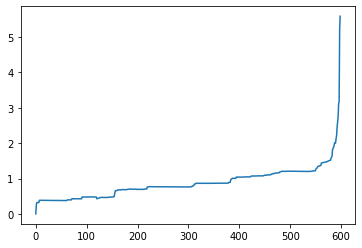

In [527]:
plt.plot(weights.detach().numpy())

<AxesSubplot:xlabel='seconds_in_bucket'>

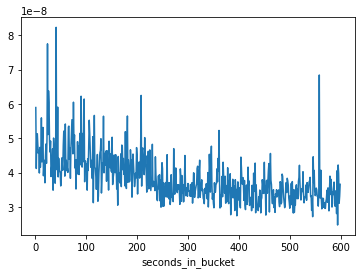

In [688]:
book.groupby('seconds_in_bucket')['square_return'].mean().plot()

<AxesSubplot:xlabel='seconds_in_bucket'>

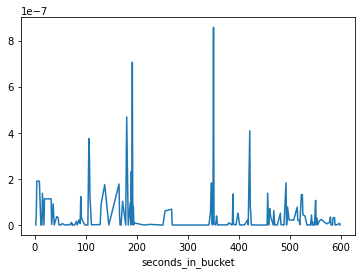

In [440]:
book[book.time_id == 32758].set_index('seconds_in_bucket')['square_return'].plot()

In [437]:
book.time_id.unique()

array([    5,    11,    16, ..., 32758, 32763, 32767], dtype=int16)

In [542]:
res = {}

for stock_id in tqdm(stock_ids):
    book = pd.read_parquet('book_train.parquet/stock_id=' + str(stock_id))
    book['wap'] = (book['bid_price1'] * book['ask_size1'] + book['ask_price1'] * book['bid_size1']) / (
    book['ask_size1'] + book['bid_size1'])
    
    book['log_price'] = np.log(book['wap'])
    book['log_return'] = book.groupby(['time_id'])['log_price'].diff()
    book['square_return'] = book['log_return'] ** 2
    book = book[~book['log_return'].isnull()]
    book['stock_id'] = stock_id
    
    book = pd.merge(book, train_targets, how='left', on=['time_id', 'stock_id'])
    
    X = pd.pivot_table(book, 
                   values='square_return', 
                   columns=['seconds_in_bucket'], 
                   index='time_id', aggfunc='last')

    X = X.fillna(0)
    y = train_targets[train_targets.stock_id == stock_id].set_index('time_id')['target'].loc[X.index]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    X_train = torch.tensor(X_train.values)
    X_test = torch.tensor(X_test.values)

    y_train = torch.tensor(y_train.values)
    y_test = torch.tensor(y_test.values)
    
    X = torch.tensor(X.values)
    y = torch.tensor(y.values)
    
    weights = torch.ones(X_train.shape[1], requires_grad=True)
    weights_poly = torch.tensor([ 1., 0., .0], requires_grad=True)
    opt = optim.Adam([weights, weights_poly], lr=0.1)
    alpha = 0.8
    beta = 1
    
    for n in range(1000):
        y_pred_temp = torch.matmul(X_train, weights) ** 0.5
        y_pred = y_pred_temp * weights_poly[0] + y_pred_temp**2 * weights_poly[1] + \
             y_pred_temp**3 * weights_poly[2]
        
        reg = weights[:-1] - weights[1: ]
        loss = my_loss(y_train, y_pred) + torch.sum(reg[reg > 0] ** 2) * alpha +torch.sum(
            weights[weights < 0] ** 2)

        loss.backward()
        opt.step()
        opt.zero_grad()
    
    res[stock_id] = (weights, weights_poly, X, y, X_train, y_train, X_test, y_test)



  0%|          | 0/112 [00:00<?, ?it/s]

  1%|          | 1/112 [00:04<07:29,  4.05s/it]

  2%|▏         | 2/112 [00:09<07:55,  4.32s/it]

  3%|▎         | 3/112 [00:15<08:47,  4.84s/it]

  4%|▎         | 4/112 [00:20<08:56,  4.97s/it]

  4%|▍         | 5/112 [00:25<09:02,  5.07s/it]

  5%|▌         | 6/112 [00:30<09:01,  5.11s/it]

  6%|▋         | 7/112 [00:35<08:51,  5.06s/it]

  7%|▋         | 8/112 [00:41<08:59,  5.19s/it]

  8%|▊         | 9/112 [00:46<09:01,  5.26s/it]

  9%|▉         | 10/112 [00:51<08:45,  5.15s/it]

 10%|▉         | 11/112 [00:57<08:53,  5.28s/it]

 11%|█         | 12/112 [01:01<08:24,  5.04s/it]

 12%|█▏        | 13/112 [01:06<08:14,  4.99s/it]

 12%|█▎        | 14/112 [01:12<08:25,  5.16s/it]

 13%|█▎        | 15/112 [01:19<09:14,  5.72s/it]

 14%|█▍        | 16/112 [01:23<08:41,  5.43s/it]

 15%|█▌        | 17/112 [01:28<08:20,  5.27s/it]

 16%|█▌        | 18/112 [01:33<07:46,  4.96s/it]

 17%|█▋        | 19/112 [01:38<07:46,  5.01s/it]

 18%|█▊        |

In [536]:
y_true = []
y_pred = []

weights = res[stock_id][0]
for stock_id in res:
    X = res[stock_id][6]
    y = res[stock_id][7]
    
    y_true.append(y.detach().numpy())
    y_pred_temp = (torch.matmul(X, weights) ** 0.5)
    y_pred_temp = y_pred_temp * weights_poly[0] + y_pred_temp**2 * weights_poly[1] + \
             y_pred_temp**3 * weights_poly[2]
    
    y_pred_temp = y_pred_temp.detach().numpy()
    
    y_pred.append(y_pred_temp)

In [537]:
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

In [538]:
rmspe(y_true, y_pred)

0.2698631769809836

In [79]:
rmspe(y_true, y_pred)

0.26542675502131957

In [586]:
rmspe(y_true, y_pred)

0.2790782247939971

In [672]:
stock_id = 105

book = pd.read_parquet('book_train.parquet/stock_id=' + str(stock_id))
book['wap'] = (book['bid_price1'] * book['ask_size1'] + book['ask_price1'] * book['bid_size1']) / (
book['ask_size1'] + book['bid_size1'])

book['log_price'] = np.log(book['wap'])
book['log_return'] = book.groupby(['time_id'])['log_price'].diff()
book['square_return'] = book['log_return'] ** 2
book = book[~book['log_return'].isnull()]
book['stock_id'] = stock_id

book = pd.merge(book, train_targets, how='left', on=['time_id', 'stock_id'])

X = pd.pivot_table(book, 
               values='square_return', 
               columns=['seconds_in_bucket'], 
               index='time_id', aggfunc='last')

X = X.fillna(0)
y = train_targets[train_targets.stock_id == stock_id].set_index('time_id')['target'].loc[X.index]
X = X.values

X = torch.tensor(X)
y = torch.tensor(y.values)

weights = torch.ones(X.shape[1], requires_grad=True)
weights_poly = torch.tensor([ 1., 0.], requires_grad=True)
opt = optim.Adam([weights, weights_poly], lr=0.01)
alpha = 0.8
beta = 1

for n in range(3000):
    if torch.sum(torch.matmul(X, weights) < 0):
        print('hi')
    y_pred_temp = torch.matmul(X, weights) ** 0.5
    y_pred = y_pred_temp * weights_poly[0] + y_pred_temp**2 * weights_poly[1] 

    reg = weights[:-1] - weights[1: ]
    loss = my_loss(y, y_pred) + torch.sum(reg[reg > 0] ** 2) * alpha +torch.sum(
        weights[weights < 0] ** 2)

    loss.backward()
    opt.step()
    opt.zero_grad()

In [673]:
weights_poly

tensor([  0.9405, -19.2642], requires_grad=True)

In [660]:
y

tensor([0.0030, 0.0010, 0.0018,  ..., 0.0016, 0.0035, 0.0014],
       dtype=torch.float64)